In [4]:
import numpy as np
from nba_api.stats.endpoints import leaguegamelog
import time
from datetime import date

def get_all_games(start_year=1946, end_year=2023):
  results = []
  for year in range(start_year, end_year):
    season = '{}-{}'.format(year, str(year + 1)[-2:])
    res = leaguegamelog.LeagueGameLog(counter=10000, season=season)
    res_frame = res.get_data_frames()[0]
    results.append(res_frame)
    time.sleep(1)
  return results
    
seasons = get_all_games(2013, 2014)

In [5]:
seasons[0].loc[0]

SEASON_ID                    22013
TEAM_ID                 1610612753
TEAM_ABBREVIATION              ORL
TEAM_NAME            Orlando Magic
GAME_ID                 0021300001
GAME_DATE               2013-10-29
MATCHUP                  ORL @ IND
WL                               L
MIN                            240
FGM                             36
FGA                             93
FG_PCT                       0.387
FG3M                             9
FG3A                            19
FG3_PCT                      0.474
FTM                              6
FTA                             10
FT_PCT                         0.6
OREB                            13
DREB                            26
REB                             39
AST                             17
STL                             10
BLK                              6
TOV                             19
PF                              26
PTS                             87
PLUS_MINUS                     -10
VIDEO_AVAILABLE     

In [6]:
# games retrieved include the stats for both teams as separate rows, so put them in 'home' or 'away' respectively
def map_home_and_away(seasons):
  results_all_season = []
  for season in seasons:
    results_for_season = []
    results_for_season.append(season[season.duplicated(subset='GAME_ID', keep='first')])
    results_for_season.append(season[season.duplicated(subset='GAME_ID', keep='last')])

    results_all_season.append(results_for_season)
    
  return results_all_season

# seasons_home_and_away = map_home_and_away(results)

In [7]:
def preprocess(seasons):
  
  # drop unnecessary columns
  for season in seasons:
    season.drop(columns=['TEAM_ABBREVIATION', 'TEAM_NAME',\
                         'MATCHUP', 'VIDEO_AVAILABLE'], inplace=True, errors='ignore')

  # convert WL to 0 and 1
  # mapped 1 and 0 to themselves because couldn't seem to get
  # na_action to ignore when already converted
  WL = {'L': 0., 'W': 1., 1.:1., 0.:0.}
  for season in seasons:
    season['WL'] = season['WL'].map(WL.get, na_action='ignore')

  # add home and away dimension
  seasons = map_home_and_away(seasons)

  # map season_id to index
  season_index = []
  for home, away in seasons:
    season_index.append(home.iloc[0]['SEASON_ID'])
    home['SEASON_ID'] = len(season_index) - 1
    away['SEASON_ID'] = len(season_index) - 1

  # map game_id to index
  game_index = []
  for home, away in seasons:
    start = len(game_index)
    game_index.extend(home['GAME_ID'].to_list())
    end = len(game_index)
    home['GAME_ID'] = range(start, end) 
    away['GAME_ID'] = range(start, end) 

  # get unique team_id's
  team_id_set = set()
  for home, _ in seasons:
    team_id_set.update(home['TEAM_ID'].unique())

  # map index to team_id
  team_index = list(team_id_set)
  # map team_id to index
  team_id_dict = {team_index[i]: i for i in range(len(team_index))}

  for home, away in seasons:
    home['TEAM_ID'] = home['TEAM_ID'].map(team_id_dict.get)
    away['TEAM_ID'] = away['TEAM_ID'].map(team_id_dict.get)

  columns = list(seasons[0][0].columns)

  dates_index = []
  for home, away in seasons:
    start = len(dates_index)
    dates_index.extend(home['GAME_DATE'].map(date.fromisoformat).to_list())
    end = len(dates_index)
    home['GAME_DATE'] = range(start, end)
    away['GAME_DATE'] = range(start, end)

  # do whatever else with pandas before they are turned into numpy
  # ...
  
  seasons[0][0].info()
  max_row = 0
  for home, _ in seasons:
    max_row = max(home.shape[-2], max_row)
    
  for i, (home, away) in enumerate(seasons):
    home.to_numpy(dtype=np.float32)
    away.to_numpy(dtype=np.float32)
    seasons[i][0] = np.pad(home, ((0, max_row - home.shape[-2]), (0, 0)), 'constant')
    seasons[i][1] = np.pad(away, ((0, max_row - away.shape[-2]), (0, 0)), 'constant')

  seasons_np = np.array(seasons, dtype=np.float32)
  
  return seasons_np, columns, season_index, game_index, team_index, dates_index

seasons_np, columns, season_index, game_index, team_index, dates_index = preprocess(seasons)

<class 'pandas.core.frame.DataFrame'>
Index: 1230 entries, 2 to 2459
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SEASON_ID   1230 non-null   int64  
 1   TEAM_ID     1230 non-null   int64  
 2   GAME_ID     1230 non-null   int64  
 3   GAME_DATE   1230 non-null   int64  
 4   WL          1230 non-null   float64
 5   MIN         1230 non-null   int64  
 6   FGM         1230 non-null   int64  
 7   FGA         1230 non-null   int64  
 8   FG_PCT      1230 non-null   float64
 9   FG3M        1230 non-null   int64  
 10  FG3A        1230 non-null   int64  
 11  FG3_PCT     1230 non-null   float64
 12  FTM         1230 non-null   int64  
 13  FTA         1230 non-null   int64  
 14  FT_PCT      1230 non-null   float64
 15  OREB        1230 non-null   int64  
 16  DREB        1230 non-null   int64  
 17  REB         1230 non-null   int64  
 18  AST         1230 non-null   int64  
 19  STL         1230 non-null   int6

/tmp/ipykernel_11785/2056047199.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home['SEASON_ID'] = len(season_index) - 1
/tmp/ipykernel_11785/2056047199.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away['SEASON_ID'] = len(season_index) - 1
/tmp/ipykernel_11785/2056047199.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [8]:
seasons[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460 entries, 0 to 2459
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SEASON_ID   2460 non-null   object 
 1   TEAM_ID     2460 non-null   int64  
 2   GAME_ID     2460 non-null   object 
 3   GAME_DATE   2460 non-null   object 
 4   WL          2460 non-null   float64
 5   MIN         2460 non-null   int64  
 6   FGM         2460 non-null   int64  
 7   FGA         2460 non-null   int64  
 8   FG_PCT      2460 non-null   float64
 9   FG3M        2460 non-null   int64  
 10  FG3A        2460 non-null   int64  
 11  FG3_PCT     2460 non-null   float64
 12  FTM         2460 non-null   int64  
 13  FTA         2460 non-null   int64  
 14  FT_PCT      2460 non-null   float64
 15  OREB        2460 non-null   int64  
 16  DREB        2460 non-null   int64  
 17  REB         2460 non-null   int64  
 18  AST         2460 non-null   int64  
 19  STL         2460 non-null  

In [9]:
seasons_np.shape

(11, 2, 1230, 25)

In [10]:
seasons_np[3][1][5:8][0]

array([ 3.000e+00,  1.400e+01,  3.695e+03,  3.695e+03,  0.000e+00,
        2.400e+02,  4.300e+01,  9.700e+01,  4.430e-01,  1.500e+01,
        4.400e+01,  3.410e-01,  1.600e+01,  2.000e+01,  8.000e-01,
        1.500e+01,  2.900e+01,  4.400e+01,  2.200e+01,  8.000e+00,
        3.000e+00,  1.600e+01,  1.900e+01,  1.170e+02, -5.000e+00],
      dtype=float32)

In [11]:
columns

['SEASON_ID',
 'TEAM_ID',
 'GAME_ID',
 'GAME_DATE',
 'WL',
 'MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'PLUS_MINUS']

In [12]:
season_index

['22013',
 '22014',
 '22015',
 '22016',
 '22017',
 '22018',
 '22019',
 '22020',
 '22021',
 '22022',
 '22023']

In [13]:
game_index[:10]

['0021300003',
 '0021300001',
 '0021300002',
 '0021300015',
 '0021300010',
 '0021300011',
 '0021300012',
 '0021300013',
 '0021300008',
 '0021300017']

In [14]:
team_index

[1610612737,
 1610612738,
 1610612739,
 1610612740,
 1610612741,
 1610612742,
 1610612743,
 1610612744,
 1610612745,
 1610612746,
 1610612747,
 1610612748,
 1610612749,
 1610612750,
 1610612751,
 1610612752,
 1610612753,
 1610612754,
 1610612755,
 1610612756,
 1610612757,
 1610612758,
 1610612759,
 1610612760,
 1610612761,
 1610612762,
 1610612763,
 1610612764,
 1610612765,
 1610612766]

In [15]:
dates_index[:5]

[datetime.date(2013, 10, 29),
 datetime.date(2013, 10, 29),
 datetime.date(2013, 10, 29),
 datetime.date(2013, 10, 30),
 datetime.date(2013, 10, 30)]

In [16]:
seasons_np.shape

(11, 2, 1230, 25)

In [17]:
seasons_np_T = seasons_np.transpose(0, 2, 1, 3)

In [18]:
seasons_np_T.shape

(11, 1230, 2, 25)

In [20]:
seasons_np_t = seasons_np_T.reshape((seasons_np_T.shape[0], seasons_np_T.shape[1], 50))

In [22]:
seasons_t = torch.from_numpy(seasons_np_t)

In [23]:
seasons_t.shape

torch.Size([11, 1230, 50])

In [98]:
Y = seasons_t[:,:,4]
Y.shape

torch.Size([11, 1230])

In [181]:
X = torch.cat((seasons_t[:,:,:4], seasons_t[:,:,5:29], seasons_t[:,:,30:]), axis=2)
X.shape

torch.Size([11, 1230, 48])

In [262]:
X_norm = nn.functional.normalize(X, p=3, dim=1)

In [184]:
X

tensor([[[ 0.0000e+00,  9.0000e+00,  0.0000e+00,  ...,  2.6000e+01,
           8.7000e+01, -1.0000e+01],
         [ 0.0000e+00,  1.7000e+01,  1.0000e+00,  ...,  2.3000e+01,
           1.1600e+02,  1.3000e+01],
         [ 0.0000e+00,  1.1000e+01,  2.0000e+00,  ...,  2.7000e+01,
           9.5000e+01, -1.2000e+01],
         ...,
         [ 0.0000e+00,  1.2000e+01,  1.2270e+03,  ...,  2.0000e+01,
           9.2000e+01, -3.0000e+00],
         [ 0.0000e+00,  5.0000e+00,  1.2280e+03,  ...,  1.7000e+01,
           1.0100e+02,  1.5000e+01],
         [ 0.0000e+00,  1.5000e+01,  1.2290e+03,  ...,  1.6000e+01,
           1.0600e+02,  1.0000e+00]],

        [[ 1.0000e+00,  1.0000e+01,  1.2300e+03,  ...,  3.0000e+01,
           1.0800e+02,  1.8000e+01],
         [ 1.0000e+00,  3.0000e+00,  1.2310e+03,  ...,  2.5000e+01,
           8.4000e+01, -1.7000e+01],
         [ 1.0000e+00,  5.0000e+00,  1.2320e+03,  ...,  2.0000e+01,
           1.0100e+02,  1.0000e+00],
         ...,
         [ 1.0000e+00,  7

In [370]:
import torch
import torch.nn as nn

class LogisticRegression(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(LogisticRegression, self).__init__()
    self.fc1 = nn.Linear(input_dim, output_dim)
    # self.fc1 = nn.Linear(input_dim, hidden_dim)
    # self.sigmoid = nn.Sigmoid()
    # self.fc2 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    out = self.fc1(x)
    # out = self.sigmoid(out)
    # out = self.fc2(out)
    return out

In [371]:
from torch.utils.data import Dataset

class GameDataset(Dataset):
  def __init__(self, x, y, transform = None):
    self.x = x
    self.y = y
    self.transform = transform
    self.len = len(x)

  def __getitem__(self, idx):
    sample = self.x[idx], self.y[idx]
    if self.transform:
      sample = self.transform(sample)
    return sample

  def __len__(self):
    return self.len
  
train_dataset = GameDataset(X_norm[0, :1000], Y[0, :1000])
test_dataset = GameDataset(X_norm[0, 1000:], Y[0, 1000:])

In [372]:
input_dim = x.shape[-1]
output_dim = 1
hidden_dim = 20

model = LogisticRegression(input_dim, hidden_dim, output_dim)

print(model)

LogisticRegression(
  (fc1): Linear(in_features=48, out_features=1, bias=True)
)


In [373]:
batch_size = 256
epochs = 1000

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [374]:
criterion = nn.BCELoss()
learning_rate = 0.1
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [375]:
# x, y = next(iter(train_loader))
# print(x.shape, y.shape)
# with torch.no_grad():
#   pred = model(x)
#   print(pred)

In [376]:
sig = nn.Sigmoid()

In [377]:
model.to('cuda')

LogisticRegression(
  (fc1): Linear(in_features=48, out_features=1, bias=True)
)

In [378]:
model.train()

training_curve = []
valid_curve = []

for epoch in range(epochs):
  for i, (x, y) in enumerate(train_loader):
    optimiser.zero_grad()
    logits = model(x.to('cuda'))
    # print(y.to(torch.long).shape, y_pred.squeeze(1).shape)
    # print(y.to(torch.long).dtype, y_pred.dtype)
    y_pred = sig(logits)
    
    correct = (torch.round(y_pred).squeeze(1) == y.to('cuda')).sum()
    
    loss = criterion(y_pred, y.to('cuda').unsqueeze(1))
    
    loss.backward()

    optimiser.step()
    if i % 10 == 0:
      print('i: {}, correct: {}, total: {}'.format(i, correct, y.size(0)))
      training_curve.append(loss.item())

  with torch.no_grad():
    correct = 0
    total = 0
    for x, y in test_loader:
      logits = model(x.to('cuda'))
      y_pred = torch.round(sig(logits)).squeeze(1)
      correct += (y_pred == y.to('cuda')).sum()
      total += y.size(0)

    accuracy = 100 * (correct / total).item()
    print(correct, total)
    print('epoch: {} accuracy: {}'.format(epoch, accuracy))
    valid_curve.append(accuracy)

    
    

i: 0, correct: 115, total: 256
tensor(188, device='cuda:0') 230
epoch: 0 accuracy: 81.73912763595581
i: 0, correct: 206, total: 256
tensor(160, device='cuda:0') 230
epoch: 1 accuracy: 69.56521272659302
i: 0, correct: 167, total: 256
tensor(182, device='cuda:0') 230
epoch: 2 accuracy: 79.13042902946472
i: 0, correct: 186, total: 256
tensor(188, device='cuda:0') 230
epoch: 3 accuracy: 81.73912763595581
i: 0, correct: 190, total: 256
tensor(189, device='cuda:0') 230
epoch: 4 accuracy: 82.17390775680542
i: 0, correct: 211, total: 256
tensor(184, device='cuda:0') 230
epoch: 5 accuracy: 79.99999523162842
i: 0, correct: 220, total: 256
tensor(187, device='cuda:0') 230
epoch: 6 accuracy: 81.30434155464172
i: 0, correct: 213, total: 256
tensor(188, device='cuda:0') 230
epoch: 7 accuracy: 81.73912763595581
i: 0, correct: 210, total: 256
tensor(183, device='cuda:0') 230
epoch: 8 accuracy: 79.56521511077881
i: 0, correct: 214, total: 256
tensor(186, device='cuda:0') 230
epoch: 9 accuracy: 80.86956

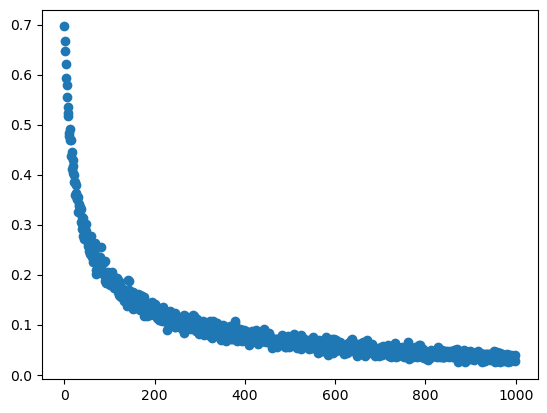

In [379]:
import matplotlib.pyplot as plt
plt.plot(training_curve, 'o')

In [380]:
valid_curve

[81.73912763595581,
 69.56521272659302,
 79.13042902946472,
 81.73912763595581,
 82.17390775680542,
 79.99999523162842,
 81.30434155464172,
 81.73912763595581,
 79.56521511077881,
 80.86956143379211,
 80.86956143379211,
 80.86956143379211,
 83.04347395896912,
 82.6086938381195,
 81.30434155464172,
 81.73912763595581,
 82.6086938381195,
 83.04347395896912,
 83.91304016113281,
 82.6086938381195,
 83.91304016113281,
 84.78260636329651,
 82.6086938381195,
 84.78260636329651,
 85.6521725654602,
 83.4782600402832,
 85.21738648414612,
 85.21738648414612,
 85.6521725654602,
 86.08695268630981,
 86.08695268630981,
 86.52173280715942,
 86.95651888847351,
 86.52173280715942,
 86.95651888847351,
 86.95651888847351,
 87.39129900932312,
 87.39129900932312,
 87.39129900932312,
 88.26086521148682,
 88.69564533233643,
 87.8260850906372,
 89.56521153450012,
 89.56521153450012,
 88.26086521148682,
 89.13043141365051,
 89.56521153450012,
 89.99999761581421,
 90.43477773666382,
 90.43477773666382,
 89.9999

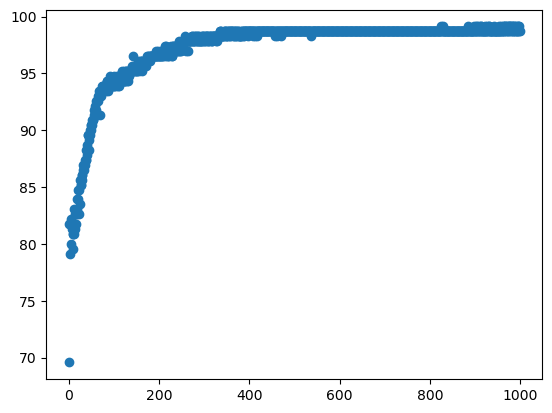

In [381]:
plt.plot(valid_curve, 'o')

In [382]:
X.shape

torch.Size([11, 1230, 48])